In [6]:
# NB03 — Set working directory to project root

import os

os.chdir("..")
print("CWD set to:", os.getcwd())

CWD set to: c:\Users\yasmi\OneDrive\Desktop\Mini-Projets\scRNA_LUAD_Immunotherapy


In [3]:
# NB03 — Bulk RNA-seq: load data and sanity check

import pandas as pd

# Load bulk expression (log2 TPM)
bulk_expr = pd.read_csv(
    "../Data/GSE207422_NSCLC_bulk_RNAseq_log2TPM.txt.gz",
    sep="\t"
)

print("Bulk expression shape (genes x samples):", bulk_expr.shape)
print("First columns:", bulk_expr.columns[:6])

# Load bulk metadata
bulk_meta = pd.read_excel(
    "../Data/GSE207422_NSCLC_bulk_RNAseq_metadata.xlsx"
)

print("\nBulk metadata shape:", bulk_meta.shape)
print("RECIST counts:\n", bulk_meta["RECIST"].value_counts())

Bulk expression shape (genes x samples): (58387, 25)
First columns: Index(['Gene', 'R20027161LR01', 'R20028573LR01', 'R20052328LR01',
       'R20030544LR01', 'R20031593LR01'],
      dtype='object')

Bulk metadata shape: (29, 12)
RECIST counts:
 RECIST
PR    14
SD     7
CR     3
Name: count, dtype: int64


In [4]:
# NB03 — Align bulk expression with metadata and keep PR / SD only

# Expression: genes x samples → set gene column as index
bulk_expr = bulk_expr.set_index("Gene")

# Keep only PR and SD samples in metadata
bulk_meta_ps = bulk_meta[bulk_meta["RECIST"].isin(["PR", "SD"])].copy()
print("Samples kept (PR+SD):", bulk_meta_ps.shape[0])
print(bulk_meta_ps["RECIST"].value_counts())

# Keep only expression columns present in metadata
common_samples = [s for s in bulk_meta_ps["Sample"] if s in bulk_expr.columns]
print("Matched samples:", len(common_samples))

bulk_expr_ps = bulk_expr[common_samples]

# Final sanity check
print("Final bulk matrix shape (genes x samples):", bulk_expr_ps.shape)

Samples kept (PR+SD): 21
RECIST
PR    14
SD     7
Name: count, dtype: int64
Matched samples: 21
Final bulk matrix shape (genes x samples): (58387, 21)


In [7]:
# NB03 — Bulk gene-set scoring (log2TPM) and PR vs SD comparison

import numpy as np
import pandas as pd

# Helper: keep only genes present in bulk matrix
present = set(bulk_expr_ps.index)

def keep(genes):
    return [g for g in genes if g in present]

# Signatures (simple, interpretable)
sig_cd8 = keep(["CD8A","CD8B","NKG7","GNLY","PRF1","GZMB","GZMH","IFNG","CCL5"])
sig_cd4 = keep(["CD4","IL7R","CCR7","LTB","SELL","TCF7","LEF1"])
sig_cyt = keep(["NKG7","GNLY","PRF1","GZMB","GZMH","IFNG","CCL4","CCL5","EOMES"])
sig_naive = keep(["IL7R","CCR7","TCF7","LEF1","LTB","SELL","MAL","LST1"])  # LST1 may be absent; kept if present

print("Genes used:", {
    "CD8": len(sig_cd8),
    "CD4": len(sig_cd4),
    "Cytotoxic": len(sig_cyt),
    "Naive/Memory": len(sig_naive),
})

# Scoring: mean(log2TPM) across genes in the signature
def score_signature(expr_df, genes):
    if len(genes) == 0:
        return pd.Series(np.nan, index=expr_df.columns)
    return expr_df.loc[genes].mean(axis=0)

scores = pd.DataFrame({
    "score_CD8": score_signature(bulk_expr_ps, sig_cd8),
    "score_CD4": score_signature(bulk_expr_ps, sig_cd4),
    "score_Cytotoxic": score_signature(bulk_expr_ps, sig_cyt),
    "score_NaiveMemory": score_signature(bulk_expr_ps, sig_naive),
})

# Attach RECIST
meta_map = bulk_meta_ps.set_index("Sample")["RECIST"]
scores["RECIST"] = scores.index.map(meta_map)

# Save
scores.to_csv("Results/bulk_signature_scores_PR_SD.csv", index=True)
print("Saved: Results/bulk_signature_scores_PR_SD.csv")

# Quick summary table (group means)
summary = scores.groupby("RECIST")[["score_CD8","score_CD4","score_Cytotoxic","score_NaiveMemory"]].mean()
summary

Genes used: {'CD8': 9, 'CD4': 7, 'Cytotoxic': 9, 'Naive/Memory': 8}
Saved: Results/bulk_signature_scores_PR_SD.csv


,score_CD8,score_CD4,score_Cytotoxic,score_NaiveMemory
RECIST,,,,
PR,4.162696,3.994204,4.221865,3.912474
SD,4.150852,4.560014,4.016250,4.494067


C:\Users\yasmi\AppData\Local\Temp\ipykernel_25960\1840018110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_25960\1840018110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_25960\1840018110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=order)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_25960\1840018110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; sup

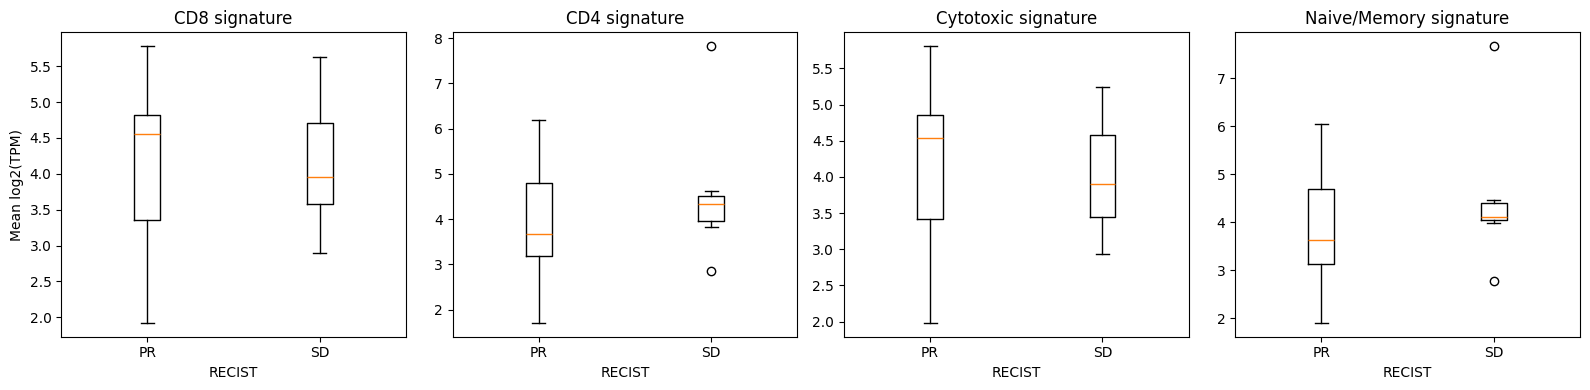

Saved: Results/Figures/bulk_signature_scores_PR_vs_SD_boxplots.png


In [9]:
# NB03 — Figures: PR vs SD bulk signature scores (boxplots) + save

import matplotlib.pyplot as plt

# Ensure RECIST order
order = ["PR", "SD"]
scores_plot = scores[scores["RECIST"].isin(order)].copy()
scores_plot["RECIST"] = pd.Categorical(scores_plot["RECIST"], categories=order, ordered=True)

metrics = ["score_CD8", "score_CD4", "score_Cytotoxic", "score_NaiveMemory"]
titles  = ["CD8 signature", "CD4 signature", "Cytotoxic signature", "Naive/Memory signature"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

for ax, m, t in zip(axes, metrics, titles):
    data = [scores_plot.loc[scores_plot["RECIST"] == g, m].dropna().values for g in order]
    ax.boxplot(data, labels=order)
    ax.set_title(t)
    ax.set_xlabel("RECIST")
    ax.set_ylabel("Mean log2(TPM)" if ax is axes[0] else "")

plt.tight_layout()
plt.savefig("Results/Figures/bulk_signature_scores_PR_vs_SD_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Results/Figures/bulk_signature_scores_PR_vs_SD_boxplots.png")

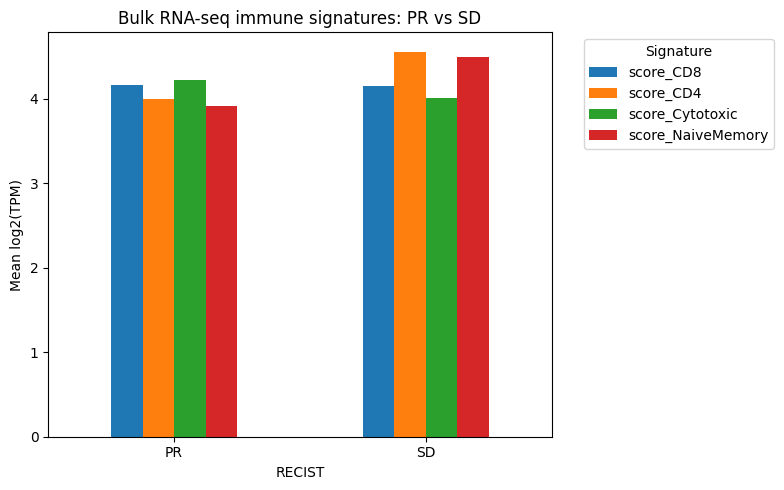

Saved: Results/Figures/bulk_signature_scores_PR_vs_SD_barplot.png


In [11]:
# NB03 — Barplot of bulk signature scores (PR vs SD)

import pandas as pd
import matplotlib.pyplot as plt

# Prepare data: mean scores per RECIST
mean_scores = (
    scores
    .groupby("RECIST")[["score_CD8","score_CD4","score_Cytotoxic","score_NaiveMemory"]]
    .mean()
    .loc[["PR","SD"]]
)

mean_scores.plot(
    kind="bar",
    figsize=(8,5),
    rot=0
)

plt.ylabel("Mean log2(TPM)")
plt.title("Bulk RNA-seq immune signatures: PR vs SD")
plt.legend(title="Signature", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig("Results/Figures/bulk_signature_scores_PR_vs_SD_barplot.png", dpi=300)
plt.show()

print("Saved: Results/Figures/bulk_signature_scores_PR_vs_SD_barplot.png")